In [48]:
from sklearn import mixture
from MNE_Pipeline import MNE_Repo_Mat as MP
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

from sklearn import mixture
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.style.use('ggplot')

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

In [14]:
if not os.path.exists('RT_dict_sub'):
    mp = MP()
    RT_dict_sub = dict()
    paths = np.sort([os.path.join('data', file) for file in os.listdir('data') if file.endswith('.mat')])
    subjects = sorted([os.path.splitext(file)[0] for file in os.listdir('data/') if file.endswith('.mat')])

    for path, subject in zip(paths, subjects):
        data = mp.load_data_mat(path)
        RT_dict_sub[subject] = data['RT']
    

    pickle.dump(RT_dict_sub, open('RT_dict_sub', 'wb'))
    
with open('RT_dict_sub', 'rb') as file:
    RT_dict_sub = pickle.load(file)
    
    
RTs = np.array([])
for s in RT_dict_sub:
    RTs = np.append(RTs, RT_dict_sub[s])
    
RTs = np.array([rt for rt in RTs if str(rt) != 'nan' and rt > 0])

X = RTs.reshape((len(RTs), 1))

## BIC Score based optimization

In [42]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 15)

cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type, random_state=2)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
bic = np.array(bic)            
A=[]
for cv_type in cv_types:
    for n_components in n_components_range:
        A.append([n_components,cv_type])
a="({},{})".format(A[bic.argmin()][0],A[bic.argmin()][1])
print("best point is({},{})".format(A[bic.argmin()][0],A[bic.argmin()][1]))

best point is(4,spherical)


In [44]:
BNPY=mixture.BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_distribution",
        n_components=4, reg_covar=0, init_params='random',
        max_iter=5000, mean_precision_prior=.8,
        random_state=42,
        verbose=0,
        covariance_type='spherical',
        verbose_interval=10)
BNPY.fit(X)

preds = BNPY.predict(X)

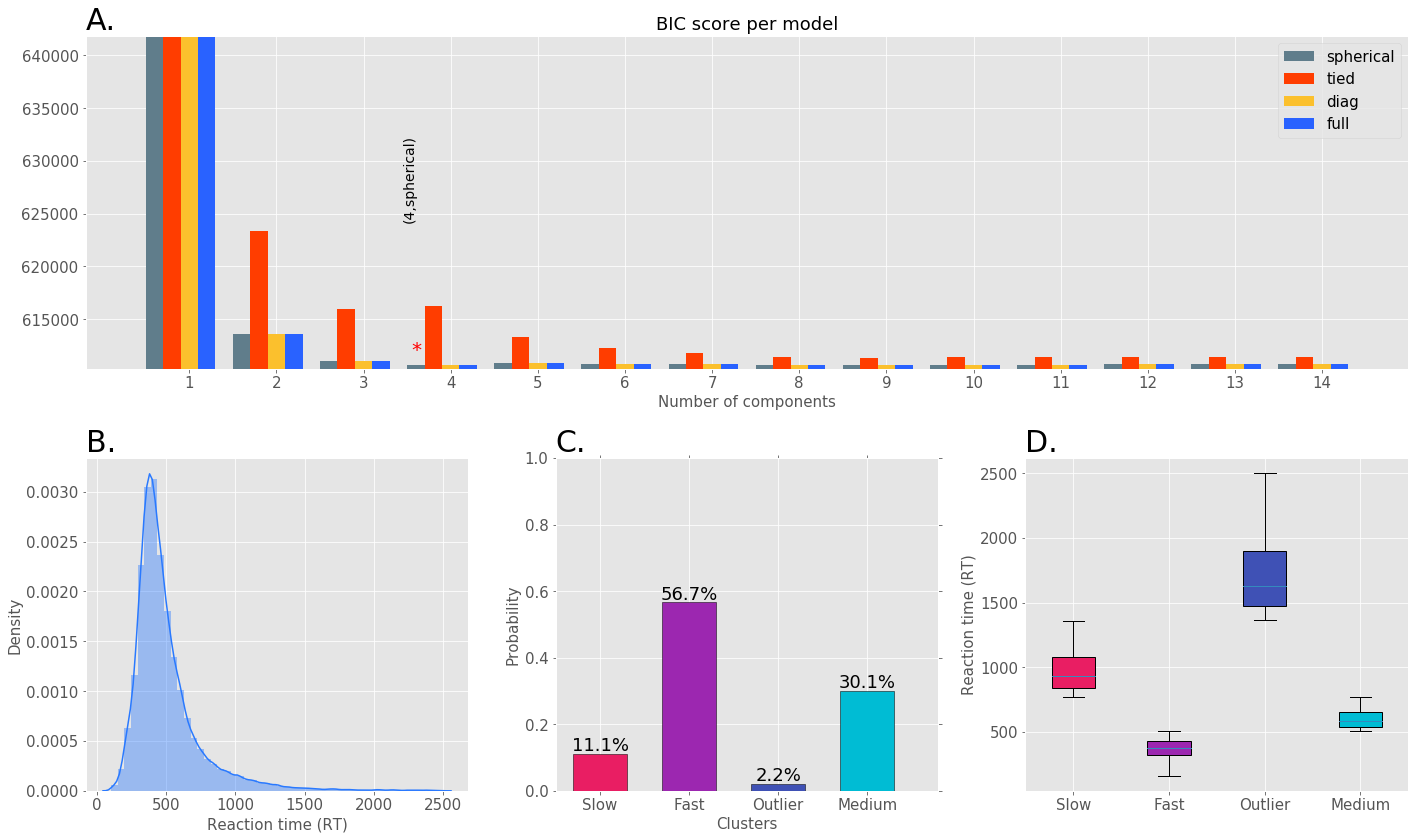

In [88]:
color_iter = itertools.cycle(['#607D8B', '#FF3D00', '#FBC02D',
                              '#2962FF'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(20,12))
gs = gridspec.GridSpec(2, 3, width_ratios=[2,2,2])

spl = plt.subplot(gs[0, 0:3])
plt.title('A.', loc='left', fontdict={'size': 30})
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))


plt.text(xpos - 0.1, bic.min() * 0.97 + .03 * bic.max(),
         '*', color='red',fontsize=20)



plt.text(xpos-.2, bic.min() * 0.97 + .05 * bic.max(),
         a, color='black',fontsize=14,rotation=90)


spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
plt.tight_layout()

plt.subplot(gs[1,0])

plt.title('B.', loc='left', fontdict={'size': 30})
sns.distplot(RTs, color='#2979FF')
plt.xlabel("Reaction time (RT)")
plt.ylabel("Density")

plt.subplot(gs[1,1])

n_components=4
index = np.arange(n_components)
colors = ['#E91E63', '#9C27B0', '#3F51B5', '#00BCD4']
plt.title('C.', loc='left', fontdict={'size': 30})
for k, w in enumerate(BNPY.weights_):
    plt.bar(k+0.2, w, width=0.6, color=colors[k], zorder=3,
            align='center', edgecolor='black')
    plt.text(k+0.2, w + 0.009, "%.1f%%" % (w * 100.),
             horizontalalignment='center')
plt.xlim(-.3, n_components)
plt.ylim(0., 1)
plt.tick_params(axis='y', which='both', left='off',
                right='off', labelleft='off')
plt.tick_params(axis='x', which='both', top='off')
plt.xticks(np.arange(4) + 0.2, ['Slow', 'Fast', 'Outlier', 'Medium'])
plt.xlabel('Clusters')
plt.ylabel('Probability')

plt.subplot(gs[1,2])
plt.title('D.', loc='left', fontdict={'size': 30})
slow_i = np.where(preds == 0)
fast_i = np.where(preds == 1)
out_i = np.where(preds == 2)
med_i = np.where(preds == 3)

slow = RTs[slow_i]
fast = RTs[fast_i]
out = RTs[out_i]
med = RTs[med_i]

data = [slow, fast, out, med]
box = plt.boxplot(data, patch_artist=True, showfliers=False)

for i,box in enumerate(box['boxes']):
    box.set_facecolor(colors[i])
plt.xticks(np.arange(1,5), ['Slow', 'Fast', 'Outlier', 'Medium'])
plt.ylabel('Reaction time (RT)')
plt.tight_layout()